<a href="https://colab.research.google.com/github/mrunalmania/BeeOrAnt-TransferLearning-resnet18/blob/main/Transfer_Learning_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import os
import time
import matplotlib.pyplot as plt

In [2]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True # this flag allows you to enable the builtin cudnn auto-tuner to find the best algorithm to use for your hardware.
plt.ion() # interactive mode on.

## Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from torch.utils.data import DataLoader
from torchvision.transforms.transforms import ToTensor
# tranforms the images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
                  for x in ['train','val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                  for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')





/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
class_names

['ants', 'bees']

## Visualize

classes: tensor([1, 0, 1, 1])
['bees', 'ants', 'bees', 'bees']


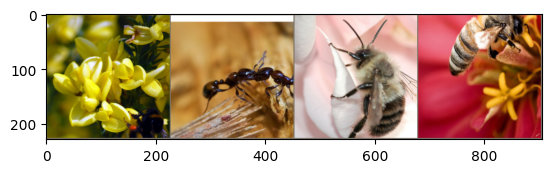

In [6]:
def imshow(inp):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  inp = std*inp + mean
  inp = np.clip(inp, 0,1)
  plt.imshow(inp)
  plt.pause(0.001)

input, classes = next(iter(dataloaders['train']))
print(f"classes: {classes}")

# make grid of inputs
out = make_grid(input)
title = [class_names[x] for x in classes]
print(title)
imshow(out)

## Training the model

In [14]:
import copy
import time
def train_model(model, loss_fn, optimizer, schedualr, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):

    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for input, classes in dataloaders[phase]:
        input = input.to(device)
        classes = classes.to(device)

        optimizer.zero_grad()

        #in train phase we need to keep track of gradient descent.
        with torch.set_grad_enabled(phase=='train'):
          output = model(input)
          _, preds = torch.max(output,1)
          loss = loss_fn(output,classes)

          # backward and optimize step only if training.
          if phase == 'train':
            loss.backward()
            optimizer.step()
        # stats
        running_loss+= loss.item()*input.size(0)
        running_corrects += torch.sum(preds==classes.data)

      if phase =='train':
        schedualr.step()
      
      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]

      print(f"{phase} Loss: {epoch_loss:.4f} || Correct: {epoch_acc:.4f}")

      if phase=='val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()

  time_elapsed = time.time() - since
  print(f"Training complete in {time_elapsed//60} mins and {time_elapsed%60}sec")
  print(f"Bess Acc: {best_acc}")

  model.load_state_dict(best_model_wts)
  return model      




## Visualizing the model prediction

In [17]:
def visualize_model(model, num_images = 6):
  was_training = model.training
  model.eval()

  images_so_far = 0
  fig = plt.figure()
  with torch.no_grad():
    for input,labels in dataloaders['val']:
      input = input.to(device)
      labels = labels.to(device)

      output = model(input)
      _,pred = torch.max(output,1)

      for j in range(input.size()[0]):
        images_so_far+=1
        ax = plt.subplot(num_images//2,2,images_so_far)
        ax.axis('off')
        ax.set_title(f"Predicted: {class_names[pred[j]]}")
        imshow(input.cpu().data[j])
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(was_training)

## Finetuning

In [10]:
from torch.optim import lr_scheduler
model_ft = models.resnet18(pretrained=True)
in_ft = model_ft.fc.in_features

model_ft.fc = nn.Linear(in_ft,len(class_names))

model_ft = model_ft.to(device=device)

# set up a loss fun and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_ft.parameters(),lr=0.001,momentum=0.9)

# LR schedualr
lr_sch = lr_scheduler.StepLR(optimizer=optimizer,step_size=7,gamma=0.1)



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 278MB/s]


## Train the model.

In [15]:
model_ft = train_model(model_ft, loss_fn, optimizer, lr_sch)

Epoch 0/24
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.2987 || Correct: 0.8648
val Loss: 0.2281 || Correct: 0.9085

Epoch 1/24
----------
train Loss: 0.2722 || Correct: 0.8852
val Loss: 0.2765 || Correct: 0.8954

Epoch 2/24
----------
train Loss: 0.2392 || Correct: 0.8852
val Loss: 0.2923 || Correct: 0.9020

Epoch 3/24
----------
train Loss: 0.2693 || Correct: 0.9057
val Loss: 0.2371 || Correct: 0.8954

Epoch 4/24
----------
train Loss: 0.2982 || Correct: 0.8648
val Loss: 0.2483 || Correct: 0.8954

Epoch 5/24
----------
train Loss: 0.3073 || Correct: 0.8811
val Loss: 0.2216 || Correct: 0.9150

Epoch 6/24
----------
train Loss: 0.2851 || Correct: 0.8811
val Loss: 0.2333 || Correct: 0.9020

Epoch 7/24
----------
train Loss: 0.2928 || Correct: 0.8730
val Loss: 0.2442 || Correct: 0.8954

Epoch 8/24
----------
train Loss: 0.2143 || Correct: 0.9221
val Loss: 0.2354 || Correct: 0.9085

Epoch 9/24
----------
train Loss: 0.3932 || Correct: 0.8361
val Loss: 0.2366 || Correct: 0.9085

Epoch 10/24
----------
train Loss: 0.2791 || Correct

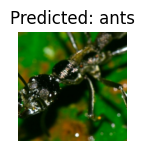

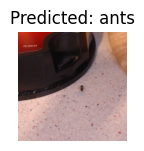

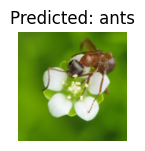

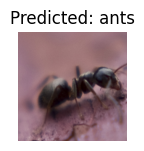

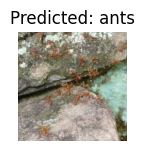

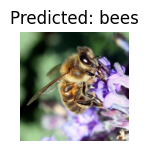

In [18]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor.

In [22]:
model_conv = models.resnet18(pretrained=True)

for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

# need to set up the loss function and optimizer.

loss_fn_1 = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_conv.parameters(), lr=0.01, momentum=0.9)

# set the lr schedular step.
exp_lr_sched = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model_conv = train_model(model_conv,loss_fn_1,optimizer,exp_lr_sched)

Epoch 0/24
----------


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 4.3151 || Correct: 0.6025
val Loss: 1.0978 || Correct: 0.9020

Epoch 1/24
----------
train Loss: 3.9716 || Correct: 0.7254
val Loss: 1.2735 || Correct: 0.8758

Epoch 2/24
----------
train Loss: 2.0363 || Correct: 0.8197
val Loss: 1.0245 || Correct: 0.9412

Epoch 3/24
----------
train Loss: 3.5038 || Correct: 0.7459
val Loss: 3.6963 || Correct: 0.7647

Epoch 4/24
----------
train Loss: 3.0045 || Correct: 0.8115
val Loss: 0.6801 || Correct: 0.9477

Epoch 5/24
----------
train Loss: 4.1999 || Correct: 0.7213
val Loss: 1.6972 || Correct: 0.8954

Epoch 6/24
----------
train Loss: 3.0369 || Correct: 0.7336
val Loss: 1.3486 || Correct: 0.8693

Epoch 7/24
----------
train Loss: 2.2198 || Correct: 0.7746
val Loss: 1.1552 || Correct: 0.9085

Epoch 8/24
----------
train Loss: 1.6402 || Correct: 0.7951
val Loss: 1.0691 || Correct: 0.9085

Epoch 9/24
----------
train Loss: 1.5997 || Correct: 0.7951
val Loss: 0.8329 || Correct: 0.9216

Epoch 10/24
----------
train Loss: 1.4296 || Correct

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


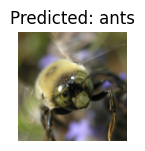

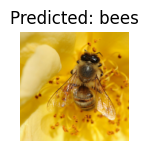

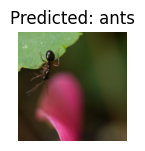

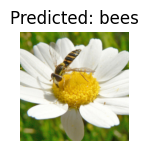

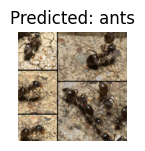

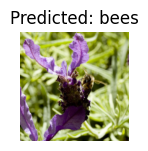

In [24]:
visualize_model(model_conv)

plt.ioff()
plt.show()